In [1]:
# Automobile Price Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split,GridSearchCV,KFold
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import Ridge
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from scipy.stats import pearsonr

In [3]:
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]

df = pd.read_csv('../input/automobiles-price-analysis/auto.csv',header=None)
df.columns = [col.replace('-','_') for col in headers ] #Replaced the dashed with _ higpen
df.replace('?',np.nan,inplace=True)

#Drop rows with null values in price...
df.dropna(subset=['price'],axis=0,inplace=True)

In [4]:
#Data typs checking....
num_cols = []
cat_cols = []
for col in df.columns:
    try:
        df[col].astype(float)
        num_cols.append(col)
    except:
        cat_cols.append(col)
c = df[num_cols].select_dtypes(object).columns
df[c] =df[c].astype(float)
df[num_cols].dtypes

symboling              int64
normalized_losses    float64
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_size            int64
bore                 float64
stroke               float64
compression_ratio    float64
horsepower           float64
peak_rpm             float64
city_mpg               int64
highway_mpg            int64
price                float64
dtype: object

In [5]:
nan_cols = [col for col in df.columns if df[col].isnull().any()]
print("Thes columns have missed values : ",nan_cols)
df[nan_cols].isnull().sum()

Thes columns have missed values :  ['normalized_losses', 'num_of_doors', 'bore', 'stroke', 'horsepower', 'peak_rpm']


normalized_losses    37
num_of_doors          2
bore                  4
stroke                4
horsepower            2
peak_rpm              2
dtype: int64

In [6]:
#imputing nan valuues
num_cols = df.select_dtypes(exclude=object).columns
cat_cols = df.select_dtypes(include=[object,'category']).columns
imputer = SimpleImputer(strategy='mean')
imputed_num_cols =pd.DataFrame(imputer.fit_transform(df[num_cols]),columns=num_cols)
imputer = SimpleImputer(strategy='most_frequent')
imputed_cat_cols =pd.DataFrame(imputer.fit_transform(df[cat_cols]),columns=cat_cols)
df = pd.concat([imputed_cat_cols,imputed_num_cols],axis=1)

#### Ordinal Encoding...

In [7]:
#Ordinal encoding...
df2 = df.copy()
cat_cols = df2.select_dtypes(include=['object','category']).columns
odi = OrdinalEncoder()
df_labeled = pd.DataFrame(odi.fit_transform(df2[cat_cols]),columns=cat_cols)
df2[cat_cols] = df_labeled

In [8]:
X = df2.copy()
y= X.pop('price')
discrete_variables = X.dtypes=='int64'

In [9]:
def mi_scores(X,y,discrete_variables):
    score = mutual_info_regression(X,y,discrete_features=discrete_variables,random_state=0)
    score = pd.Series(score,name='MI_Scores',index=X.columns)
    return score.sort_values(ascending=False)

mi_scores = mi_scores(X,y,discrete_variables)
mi_scores

curb_weight          0.896050
highway_mpg          0.873000
horsepower           0.844970
engine_size          0.832742
city_mpg             0.743726
width                0.672625
wheel_base           0.590552
length               0.584117
bore                 0.468195
fuel_system          0.459356
stroke               0.361772
height               0.340586
drive_wheels         0.333324
num_of_cylinders     0.308488
make                 0.242518
symboling            0.230500
compression_ratio    0.191505
normalized_losses    0.180746
peak_rpm             0.165067
engine_type          0.162915
aspiration           0.091703
body_style           0.057861
fuel_type            0.038389
engine_location      0.000000
num_of_doors         0.000000
Name: MI_Scores, dtype: float64

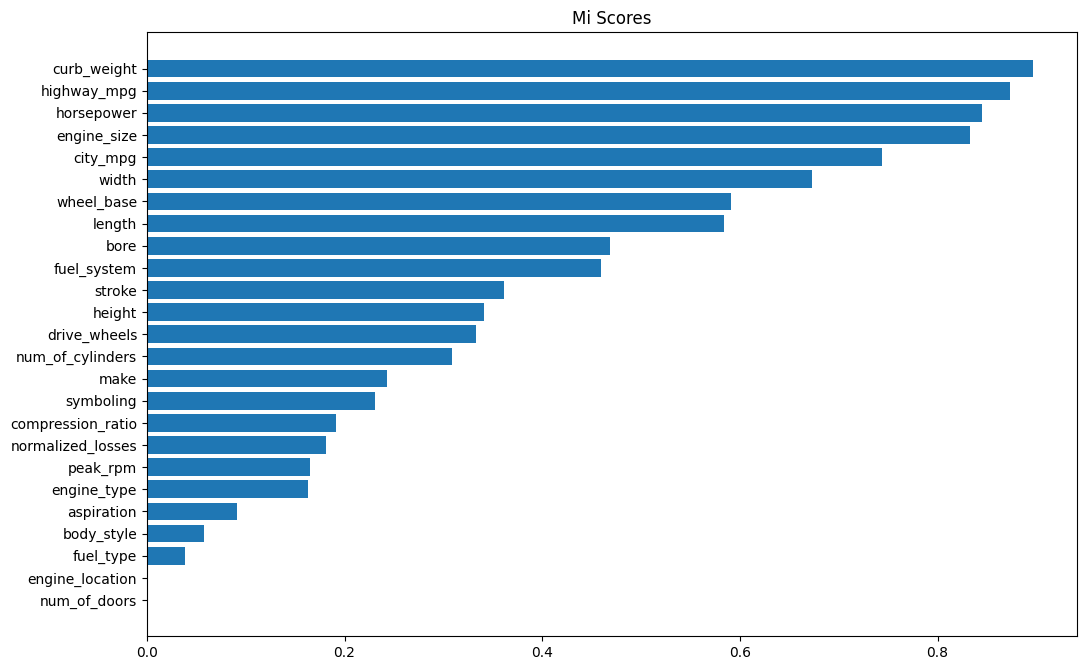

In [10]:
def plot_miscores(mi_scores):
    
    scores = mi_scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width,scores)
    plt.yticks(width,ticks)
    plt.title("Mi Scores")   

plt.figure(dpi=100,figsize=(12,8))
plot_miscores(mi_scores)

In [11]:
def pred(x_train,x_val,y_train,y_val,model):
    model = model
    model.fit(x_train,y_train)
    preds = model.predict(x_val)
    print("Actual : ",y_val[0:5].tolist())
    print('Predicted :',preds[0:5].round())
    score = model.score(x_val,y_val)
    
    #plotting the line..
    plt.figure(figsize=(8,6))
    ax1 = sns.distplot(y_val, hist=False, color="r", label='Actual')
    ax2 = sns.distplot(preds, hist=False, color="b", label='Predicted',ax=ax1)
    plt.title('Actual vs Predicted prices')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')
    plt.show()
    plt.close()
    return score

Actual :  [6295.0, 10698.0, 13860.0, 13499.0, 15750.0]
Predicted : [ 6793.  9442. 20766. 21884. 19635.]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


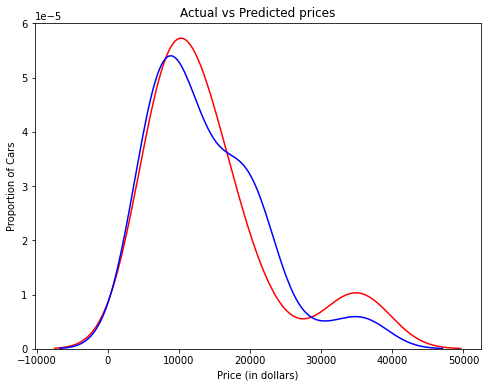

0.7598780049072772

In [12]:
features = ['curb_weight', 'highway_mpg', 'horsepower', 'engine_size','make']
x_train,x_val,y_train,y_val = train_test_split(X[features],y,test_size=0.2,random_state=0)


pred(x_train,x_val,y_train,y_val,LinearRegression())

### Polynominal regression...

Actual :  [6295.0, 10698.0, 13860.0, 13499.0, 15750.0]
Predicted : [ 7784. 10532. 25099. 17652. 16871.]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


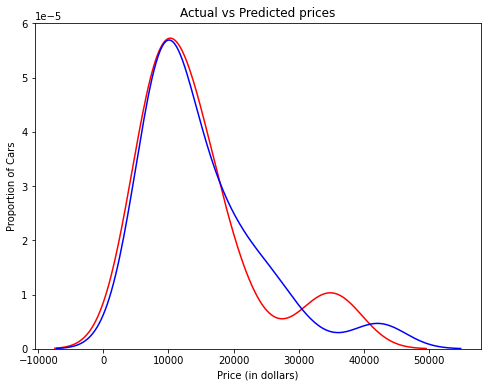

0.7538631298290531

In [13]:
poly = PolynomialFeatures(degree=2)
p_xtrain = poly.fit_transform(x_train)
p_xval = poly.fit_transform(x_val)

#predicting with polynominal regression...
pred(p_xtrain,p_xval,y_train,y_val,LinearRegression())

### Ridge Regression...

Actual :  [6295.0, 10698.0, 13860.0, 13499.0, 15750.0]
Predicted : [ 6793.  9442. 20766. 21884. 19635.]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


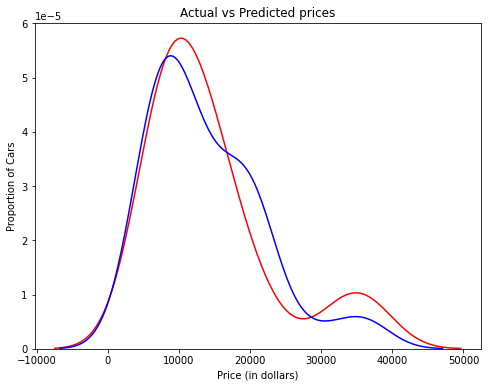

0.7598783747467354

In [14]:
pred(x_train,x_val,y_train,y_val,Ridge(alpha=0.1))

### Polynominal Ridge regression...

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.27484e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Actual :  [6295.0, 10698.0, 13860.0, 13499.0, 15750.0]
Predicted : [ 7772. 10513. 25067. 17649. 16879.]


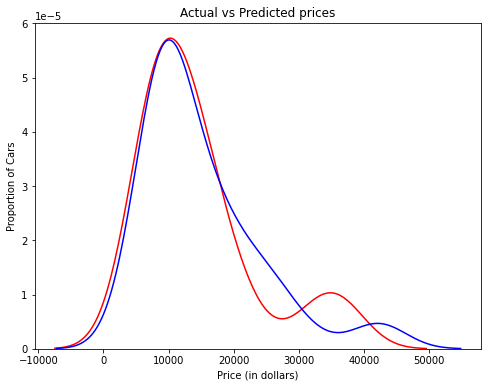

0.7544072576233659

In [15]:
pred(p_xtrain,p_xval,y_train,y_val,Ridge(alpha=0.1))

### Decission Tree 

Actual :  [6295.0, 10698.0, 13860.0, 13499.0, 15750.0]
Predicted : [ 8384.  8384. 16065. 16065. 16065.]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


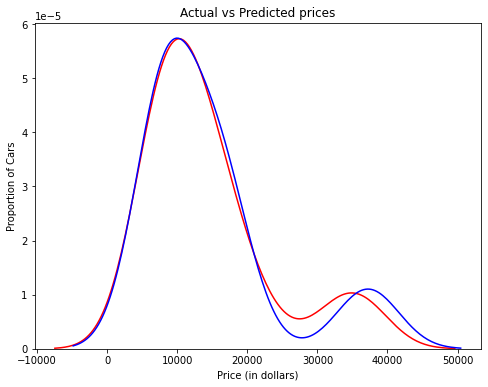

THe score is : 0.8833954798274516


In [16]:
p=pred(x_train,x_val,y_train,y_val,DecisionTreeRegressor(max_depth=2,random_state=0))
print('THe score is :',p)

### Random Forest...

Actual :  [6295.0, 10698.0, 13860.0, 13499.0, 15750.0]
Predicted : [ 6245.  8705. 17948. 15902. 16753.]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


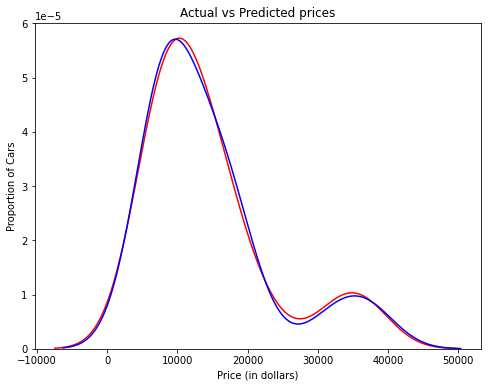

THe score is : 0.9298524043544792


In [17]:
p=pred(x_train,x_val,y_train,y_val,RandomForestRegressor(n_estimators=50,random_state=0))
print('THe score is :',p)

### Cross Validation for best estimator...

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

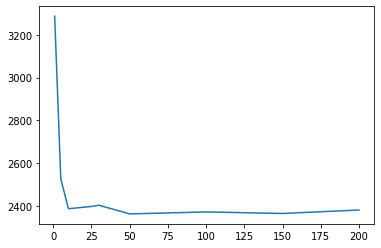

In [18]:
def score(n):
    pipe = Pipeline(steps=[('model',RandomForestRegressor(n_estimators=n,random_state=0))])
    score = -1*cross_val_score(pipe,X[features],y,cv=5,scoring='neg_mean_absolute_error',)
    return score.mean()
d={}
for i in [1,5,10,25,30,50,100,150,200]:
    s = score(i)
    d[i]=s
sns.lineplot(d.keys(),d.values())

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price'>

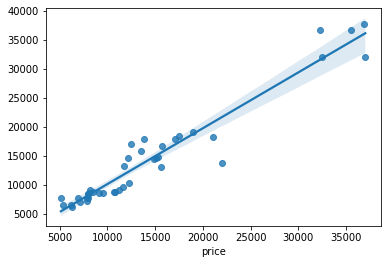

In [19]:
rf = RandomForestRegressor(n_estimators=50,random_state=0)
rf.fit(x_train,y_train)
preds = rf.predict(x_val)
sns.regplot(y_val,preds)

### Creatng Features...

In [20]:
x1 = pd.DataFrame()
x1['mpghpRatio'] = df['horsepower']/df['highway_mpg']
x1['carsize']=      df['curb_weight']/(df['length']+df['width']+df2['height'])
x1['bore_stroke'] = df['bore']+df['stroke']

x2 = pd.get_dummies(df['fuel_type'])
x3 = pd.DataFrame()
x3['Fuel_cylinders_make'] = df[['make','fuel_system','num_of_cylinders']].apply('_'.join,axis=1)
x3 =pd.DataFrame(odi.fit_transform(x3),columns=x3.columns)

final_x = X.join([x1,x2,x3])



Actual :  [6295.0, 10698.0, 13860.0, 13499.0, 15750.0]
Predicted : [ 6198.  8587. 16947. 15774. 16235.]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


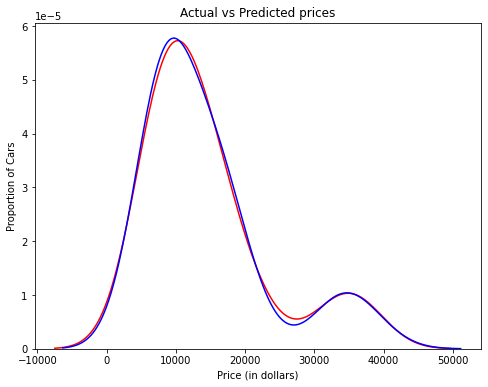

THe score is : 0.9538774931785968


In [21]:
features2 = ['engine_size','mpghpRatio','carsize','bore_stroke','Fuel_cylinders_make']

x_train,x_val,y_train,y_val = train_test_split(final_x[features2],y,test_size=0.2,random_state=0)
p=pred(x_train,x_val,y_train,y_val,RandomForestRegressor(n_estimators=100,random_state=0))
print('THe score is :',p)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Trainind Data accuracy :  0.9866713526185141
Testing Data accurcy :  0.9519135156347951


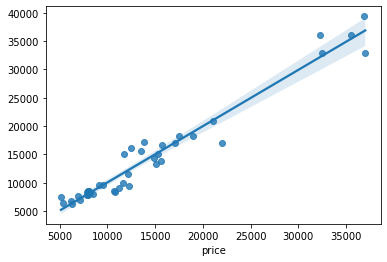

In [22]:
rf = RandomForestRegressor(n_estimators=50,random_state=0)
rf.fit(x_train,y_train)
preds = rf.predict(x_val)
sns.regplot(y_val,preds)
print('Trainind Data accuracy : ',rf.score(x_train,y_train))
print('Testing Data accurcy : ',rf.score(x_val,y_val))